In [9]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [10]:
train_data = TabularDataset(f'Data/phil_socdata_train.csv')
train_data.head()

Loaded data from: reformated3.csv | Columns = 4 / 4 | Rows = 445633 -> 445633


,SOC,V,I,T
0,100.000031,400.75,0.000000,15.5
1,100.000031,400.75,-0.270000,15.5
2,100.000031,400.75,-0.539999,15.5
3,100.000031,400.75,-0.809999,15.5
4,100.000031,400.75,-1.079998,15.5


In [11]:
label = 'SOC'
train_data[label].describe()

count    445633.000000
mean         67.546928
std          24.722213
min           0.000000
25%          48.235310
50%          72.941200
75%          88.627480
max         100.000031
Name: SOC, dtype: float64

In [12]:
predictor = TabularPredictor(label=label).fit(train_data)
'''
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 30*60  # train various models for ~10 min
num_trials = 50  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

predictor = TabularPredictor(label=label).fit(
    train_data, time_limit=time_limit, auto_stack=True,
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)
'''

No path specified. Models will be saved in: "AutogluonModels\ag-20230327_033641\"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230327_033641\"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    445633
Train Data Columns: 3
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 67.54693, 24.72221)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of

[1000]	valid_set's rmse: 2.99756
[2000]	valid_set's rmse: 2.87685
[3000]	valid_set's rmse: 2.79285
[4000]	valid_set's rmse: 2.74595
[5000]	valid_set's rmse: 2.70944
[6000]	valid_set's rmse: 2.66799
[7000]	valid_set's rmse: 2.63084
[8000]	valid_set's rmse: 2.60247
[9000]	valid_set's rmse: 2.58137
[10000]	valid_set's rmse: 2.56166


	-2.5617	 = Validation score   (-root_mean_squared_error)
	58.05s	 = Training   runtime
	1.16s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 2.25126
[2000]	valid_set's rmse: 2.11861
[3000]	valid_set's rmse: 2.04939
[4000]	valid_set's rmse: 2.015
[5000]	valid_set's rmse: 1.98467
[6000]	valid_set's rmse: 1.94008
[7000]	valid_set's rmse: 1.92013
[8000]	valid_set's rmse: 1.90825
[9000]	valid_set's rmse: 1.88914
[10000]	valid_set's rmse: 1.8792


	-1.8782	 = Validation score   (-root_mean_squared_error)
	36.87s	 = Training   runtime
	0.78s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-1.9109	 = Validation score   (-root_mean_squared_error)
	64.99s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ...
	-1.8185	 = Validation score   (-root_mean_squared_error)
	310.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.696	 = Validation score   (-root_mean_squared_error)
	33.1s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-3.1326	 = Validation score   (-root_mean_squared_error)
	212.51s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-1.9433	 = Validation score   (-root_mean_squared_error)
	119.53s	 = Training   runtime
	1.07s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-3.3958	 = Validation score   (-root_mean_squared_error)
	154.91s	 = Training   runtime
	0.01s	 = Valida

[1000]	valid_set's rmse: 1.90998
[2000]	valid_set's rmse: 1.79106
[3000]	valid_set's rmse: 1.76938
[4000]	valid_set's rmse: 1.75807
[5000]	valid_set's rmse: 1.73375
[6000]	valid_set's rmse: 1.72895
[7000]	valid_set's rmse: 1.73147
[8000]	valid_set's rmse: 1.72469
[9000]	valid_set's rmse: 1.71752
[10000]	valid_set's rmse: 1.71503


	-1.7149	 = Validation score   (-root_mean_squared_error)
	54.13s	 = Training   runtime
	1.07s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-1.6456	 = Validation score   (-root_mean_squared_error)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1055.27s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230327_033641\")


"\nimport autogluon.core as ag\n\nnn_options = {  # specifies non-default hyperparameter values for neural network models\n    'num_epochs': 10,  # number of training epochs (controls training time of NN models)\n    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)\n    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)\n    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)\n}\n\ngbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees\n    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)\n    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)\n}\n\nhyperparameters = {  # hyperparameter

In [13]:
test_data = TabularDataset(f'Data/phil_socdata_train.csv')

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

Loaded data from: Data/Drive86_soc.csv | Columns = 4 / 4 | Rows = 5617 -> 5617


0    57.259529
1    57.067055
2    57.067055
3    57.067055
4    57.067055
Name: SOC, dtype: float32

In [14]:
predictor.evaluate(test_data, silent=True)

c:\Users\kwitv\Documents\MARC\SOCprediction\venv\lib\site-packages\autogluon\tabular\predictor\predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -1.0560391855679765,
 'mean_squared_error': -1.1152187614550753,
 'mean_absolute_error': -0.7516024883589931,
 'r2': 0.9939006611298928,
 'pearsonr': 0.997022724957373,
 'median_absolute_error': -0.5520687123730461}

In [15]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-0.203728,-2.279560,0.047874,0.023092,0.434044,0.047874,0.023092,0.434044,1,True,2
1,RandomForestMSE,-0.871023,-1.910907,0.570428,0.083176,64.988500,0.570428,0.083176,64.988500,1,True,5
2,LightGBMLarge,-1.008117,-1.714939,1.988180,1.073730,54.133348,1.988180,1.073730,54.133348,1,True,11
3,ExtraTreesMSE,-1.024158,-1.696011,0.544203,0.069324,33.101985,0.544203,0.069324,33.101985,1,True,7
4,WeightedEnsemble_L2,-1.056039,-1.645584,2.631068,1.152031,398.100598,0.027440,0.000000,0.426771,2,True,12
5,XGBoost,-1.199567,-1.943293,1.514920,1.072439,119.528563,1.514920,1.072439,119.528563,1,True,9
6,LightGBM,-1.327724,-1.878249,1.198714,0.784835,36.865330,1.198714,0.784835,36.865330,1,True,4
7,KNeighborsUnif,-1.426834,-2.543032,0.047238,0.029348,0.405009,0.047238,0.029348,0.405009,1,True,1
8,CatBoost,-1.682639,-1.818520,0.071245,0.008977,310.438493,0.071245,0.008977,310.438493,1,True,6
9,LightGBMXT,-2.278214,-2.561662,1.579277,1.162385,58.050594,1.579277,1.162385,58.050594,1,True,3


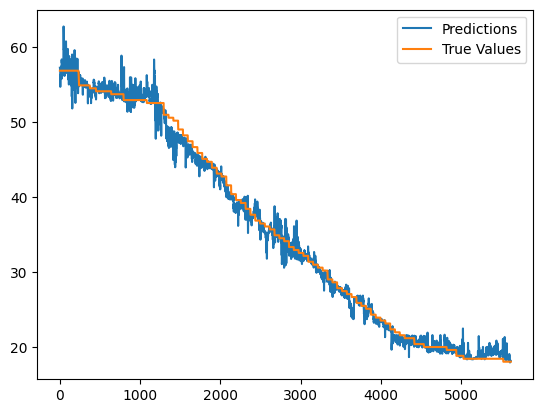

In [16]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred, label="Predictions")
plt.plot(test_data[label], label="True Values")
plt.legend()
plt.show()